Conectando ao Google Drive para obter as imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importação das bibliotecas necessárias

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array

from tqdm import tqdm_notebook


from keras import Model
from keras.utils import Sequence
from keras.saving import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import ResNet50

Carrega os caminhos para as imagens e separa os arquivos que serão usados para treino e para teste

In [ ]:
from os import listdir

image_path = '/content/drive/MyDrive/TCC/images_cut/'
labels_path = '/content/drive/MyDrive/TCC/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.16, random_state=13)

train_imgs= [image_path + i for i in train_files]
train_masks= [ labels_path + i for i in train_files]

val_imgs = [image_path + i for i in val_files]
val_masks = [labels_path + i for i in val_files]

In [ ]:
print("Training images:", len(train_imgs))
print("Validation images:", len(val_imgs))

Training images: 84
Validation images: 16


In [ ]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

### Definição do gerador de dados

Será necessário para evitar que todas as imagens sejam carregadas em memória.
Fonte: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
class DataGenerator(Sequence):

    def __init__(self,
                 images,
                 labels,
                 batch_size=16,
                 dim=(224,224,3),
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.images[i], target_size=self.dim)
            img = img_to_array(img)/255
            batch_imgs.append(img)
            label = load_img(self.labels[i], target_size=(224,224,1))
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)

        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels,
                                                                  dtype = np.float32)

In [ ]:
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-white')
import seaborn as sns
# sns.set_style("white")

def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    print(y[0].shape)
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

In [ ]:
batch_size = 16
train_generator = DataGenerator(train_imgs, train_masks, batch_size=batch_size,
                                dim=(224,224,3), shuffle=True)
train_generator.__getitem__(1)
train_steps = train_generator.__len__()

<ipython-input-61-655730d92d64>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-61-655730d92d64>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


<ipython-input-61-655730d92d64>:46: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_erosion(mp.binary_erosion(label))
<ipython-input-61-655730d92d64>:47: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


(224, 224, 1)


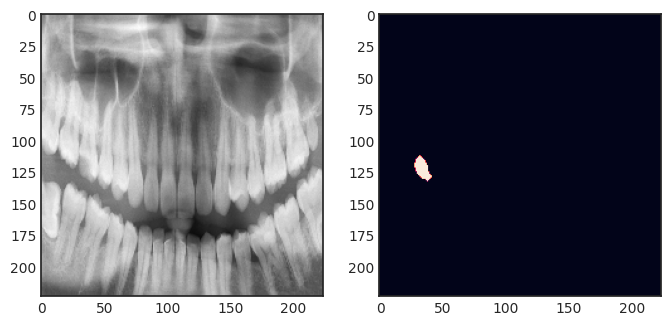

In [ ]:
display_sample(train_generator.__getitem__(2), (224,224))

In [ ]:
val_generator = DataGenerator(val_imgs, val_masks, batch_size=batch_size,
                              dim=(img_w_target,img_h_target,3), shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images

# Modelo de U-Net com backbone constrúido com ResNet50 pré-treinada

In [ ]:
def conv_block(inputs, filter_count, kernel_size=3):
    x = Conv2D(
        filter_count,
        kernel_size,
        padding = 'same',
        kernel_initializer = 'he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(
        filter_count,
        kernel_size,
        padding = 'same',
        kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, filter_count):

    x = Conv2DTranspose(
        filter_count,
        2,
        strides = (2, 2),
        activation = 'relu',
        padding = 'same',
        kernel_initializer = 'he_normal')(inputs)

    x = Concatenate()([x,skip])

    x = conv_block(x, filter_count, 3)

    return x

In [ ]:
def UnetResNetModel(input_shape):
    inputs = Input(input_shape, name = 'input')

    resnet50 = ResNet50(include_top=False, weights="imagenet", pooling="max",
                        input_tensor=inputs, input_shape=input_shape)

    skip1 = resnet50.get_layer("input").output
    skip2 = resnet50.get_layer("conv1_relu").output
    skip3 = resnet50.get_layer("conv2_block3_out").output
    skip4 = resnet50.get_layer("conv3_block4_out").output

    center = resnet50.get_layer("conv4_block6_out").output

    d1 = decoder_block(center, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)

    outputs = Conv2D(1, (3), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


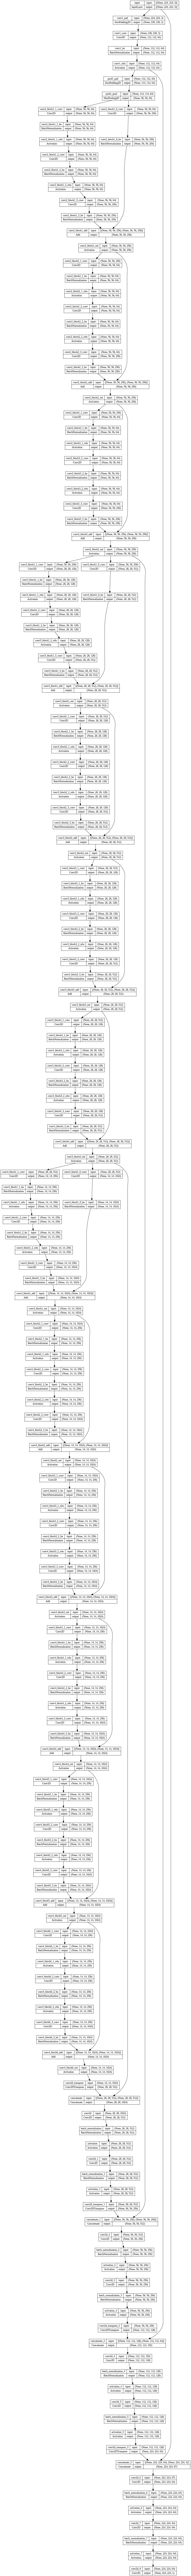

In [ ]:
from keras.utils import plot_model

model = UnetResNetModel(input_shape=(img_w_target, img_h_target, 3))
plot_model(model, show_shapes=True)


In [ ]:
from keras.losses import binary_crossentropy, BinaryCrossentropy

alpha = 0.25
gamma = 2

@register_keras_serializable(package="unetVgg16", name="jaccard_index")
def jaccard_index(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Jaccard_index
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum((y_true_f + y_pred_f) - (y_true_f * y_pred_f))
    return 1 - (intersection / union)

@register_keras_serializable(package="unetVgg16", name="dice_coef")
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

@register_keras_serializable(package="unetVgg16", name="generalized_dice_coefficient")
def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

@register_keras_serializable(package="unetVgg16", name="dice_loss")
def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

@register_keras_serializable(package="unetVgg16", name="soft_dice")
def soft_dice(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    dice_numerator = (2 * K.sum(y_pred * y_true, axis = axis)) + epsilon
    dice_denominator = K.sum(y_pred * y_pred, axis = axis) + K.sum(y_true * y_true,
                                                                   axis=axis) + epsilon
    softDice_loss = 1 - K.mean(dice_numerator/dice_denominator)
    return softDice_loss

@register_keras_serializable(package="unetVgg16", name="bce_softDice_loss")
def bce_softDice_loss(y_true, y_pred):
    w1 = 0.6
    w2 = 0.4
    loss = w1 * binary_crossentropy(y_true, y_pred) + w2 * soft_dice(y_true,y_pred)
    return loss

@register_keras_serializable(package="unetVgg16", name="log_cosh_dice_loss")
def log_cosh_dice_loss(y_true, y_pred):
    x = dice_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

@register_keras_serializable(package="unetVgg16", name="bce_dice_loss")
def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)) / 2.0

@register_keras_serializable(package="unetVgg16", name="focal_loss_with_logits")
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
        -logits)) * (weight_a + weight_b) + logits * weight_b

@register_keras_serializable(package="unetVgg16", name="focal_loss")
def focal_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true,
                                       alpha=alpha, gamma=gamma, y_pred=y_pred)
    return tf.reduce_mean(loss)

@register_keras_serializable(package="unetVgg16", name="tversky_index")
def tversky_index(y_true, y_pred):
    smooth = 1
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                1 - alpha) * false_pos + smooth)

@register_keras_serializable(package="unetVgg16", name="tversky_loss")
def tversky_loss(y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

@register_keras_serializable(package="unetVgg16", name="focal_tversky")
def focal_tversky(y_true, y_pred):
    pt_1 = tversky_index(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)

@register_keras_serializable(package="unetVgg16", name="ssim_loss")
def ssim_loss(y_true, y_pred):
    """
    Structural Similarity Index (SSIM) loss
    """
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1)

@register_keras_serializable(package="unetVgg16", name="basnet_hybrid_loss")
def basnet_hybrid_loss(y_true, y_pred):
    """
    Hybrid loss proposed in BASNET (https://arxiv.org/pdf/2101.04704.pdf)
    The hybrid loss is a combination of the binary cross entropy, structural similarity
    and intersection-over-union losses, which guide the network to learn
    three-level (i.e., pixel-, patch- and map- level) hierarchy representations.
    """
    bce_loss = BinaryCrossentropy(from_logits=False)
    bce_loss = bce_loss(y_true, y_pred)

    ms_ssim_loss = (y_true, y_pred)
    j_loss = jaccard_index(y_true, y_pred)

    return bce_loss + ms_ssim_loss + j_loss

@register_keras_serializable(package="unetVgg16", name="unet3p_hybrid_loss")
def unet3p_hybrid_loss(y_true, y_pred):
    """
    Hybrid loss proposed in UNET 3+ (https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf)
    Hybrid loss for segmentation in three-level hierarchy – pixel, patch and map-level,
    which is able to capture both large-scale and fine structures with clear boundaries.
    """
    f_loss = focal_loss(y_true, y_pred)
    ms_ssim_loss = ssim_loss(y_true, y_pred)
    j_loss = jaccard_index(y_true, y_pred)

    return f_loss + ms_ssim_loss + j_loss

In [ ]:
from keras.optimizers import Adam

model.compile(optimizer='adam', loss=bce_dice_loss, metrics = ['accuracy', jaccard_index])
mc = ModelCheckpoint(mode='max', filepath='/content/drive/MyDrive/TCC/top.model.keras',
                     save_best_only='True', save_weights_only='True', verbose=1)
callbacks = [mc]
model.metrics_names

[]

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [ ]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=80,
                          validation_data=val_generator,validation_steps=val_steps)

In [ ]:
model_history.history.keys()

In [ ]:
fig, (ax_loss, ax_acc, ax_iou) = plt.subplots(1, 3, figsize=(15,5))
ax_loss.plot(model_history.epoch, model_history.history["loss"], label="Train loss")
ax_loss.plot(model_history.epoch, model_history.history["val_loss"], label="Validation loss")
ax_acc.plot(model_history.epoch, model_history.history["accuracy"], label="Train accuracy")
ax_acc.plot(model_history.epoch, model_history.history["val_accuracy"], label="Validation accuracy")
ax_iou.plot(model_history.epoch, model_history.history["jaccard_index"], label="Train Iou")
ax_iou.plot(model_history.epoch, model_history.history["val_jaccard_index"], label="Validation Iou")

In [ ]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)

    # mask = np.reshape(mask,(224,224,3))
    return mask

In [ ]:
def overlay_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlay a mask on an image.

    Args:
        image: The image to overlay the mask on.
        mask: The mask to overlay.
        color: The color of the mask.
        alpha: The transparency of the mask.

    Returns:
        The image with the mask overlayed.
    """
    print(type(mask))
    mask = np.where(mask > 0.5, 1, 0)

    image_with_mask = image.copy()

    image_with_mask[mask == 1] = image_with_mask[mask == 1] * alpha

    return image_with_mask


(224, 224, 3)
372.png
1/1 [==============================] - 2s 2s/step
<class 'numpy.ndarray'>
(224, 224, 3)
812.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
935.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1083.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
724.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
1067.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
758.png
1/1 [==============================] - 0s 27ms/step


<ipython-input-22-f218f708dca1>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


<class 'numpy.ndarray'>
(224, 224, 3)
706.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
804.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
769.png
1/1 [==============================] - 0s 27ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
708.png
1/1 [==============================] - 0s 25ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
875.png
1/1 [==============================] - 0s 25ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
354.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
861.png
1/1 [==============================] - 0s 25ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
710.png
1/1 [==============================] - 0s 26ms/step
<class 'numpy.ndarray'>
(224, 224, 3)
323.png
1/1 [==============================] - 0s 25ms/step
<class 'numpy.ndarray'>


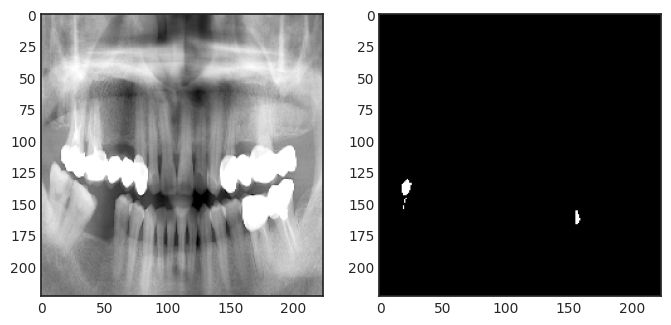

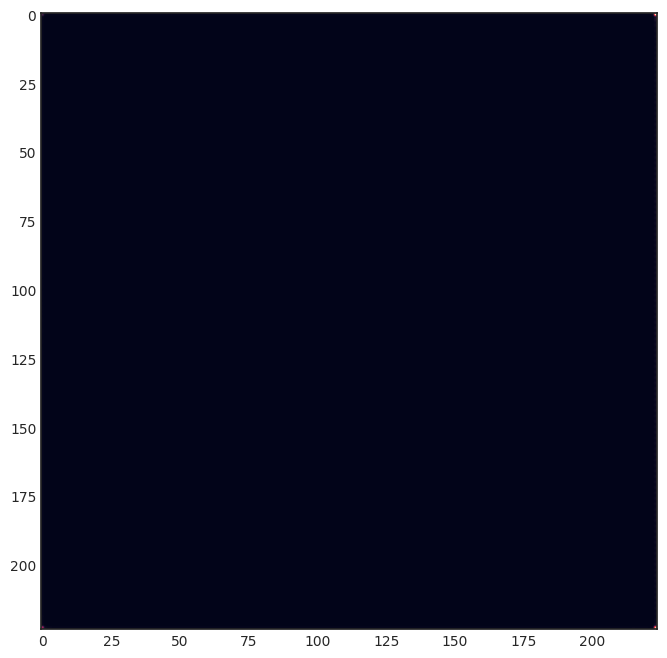

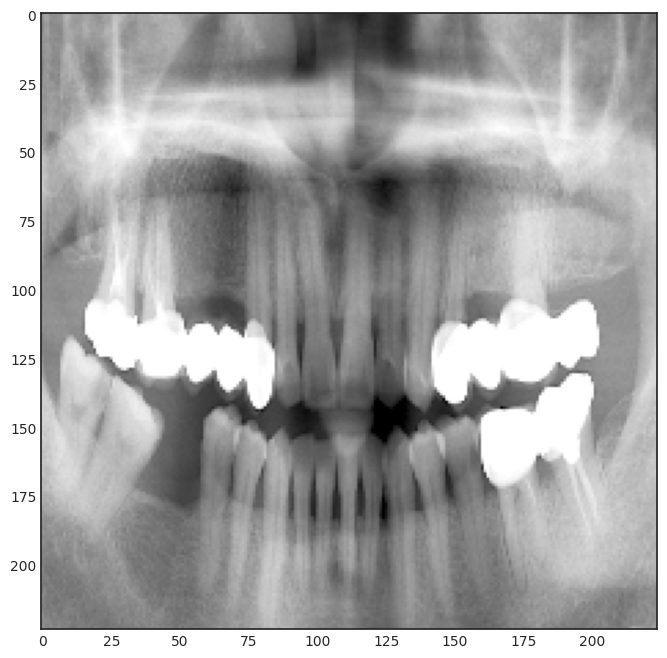

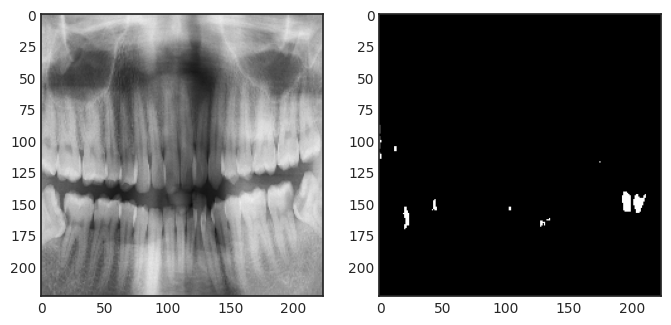

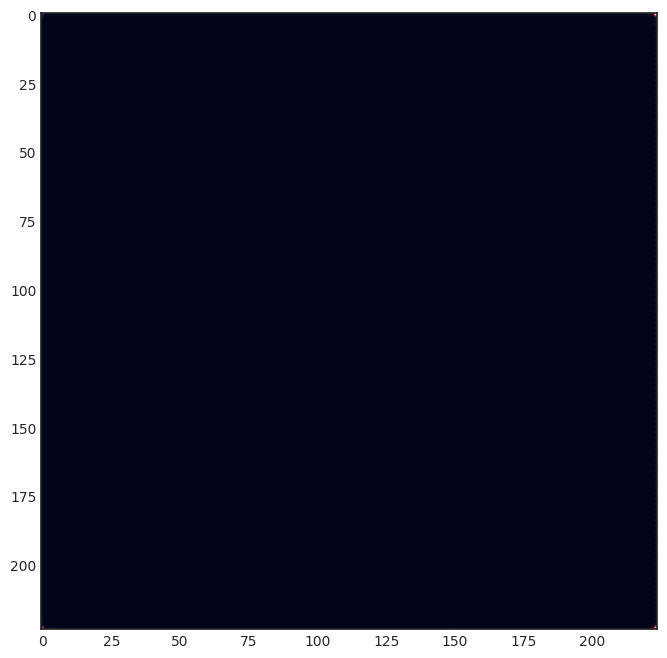

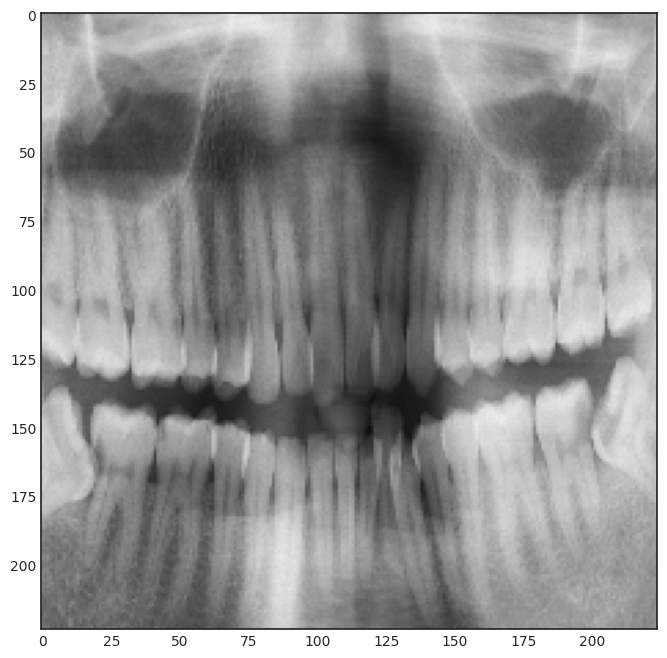

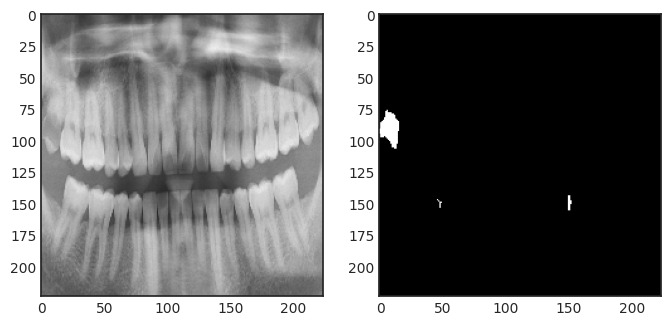

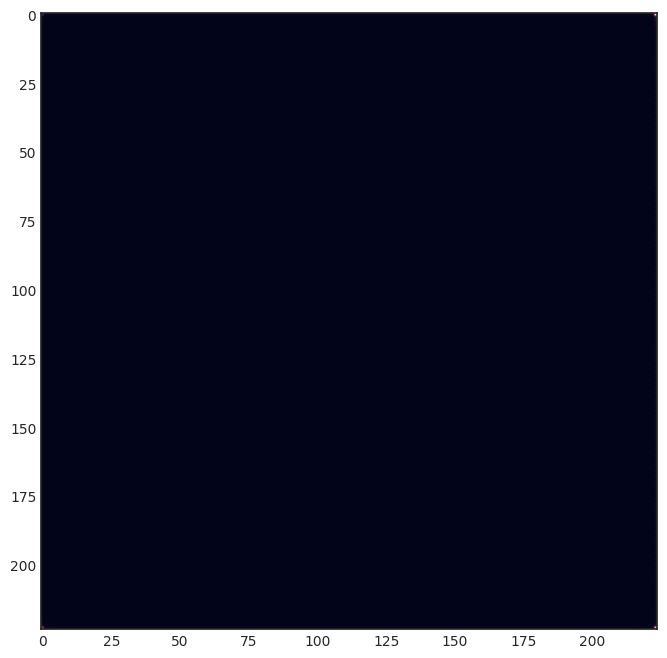

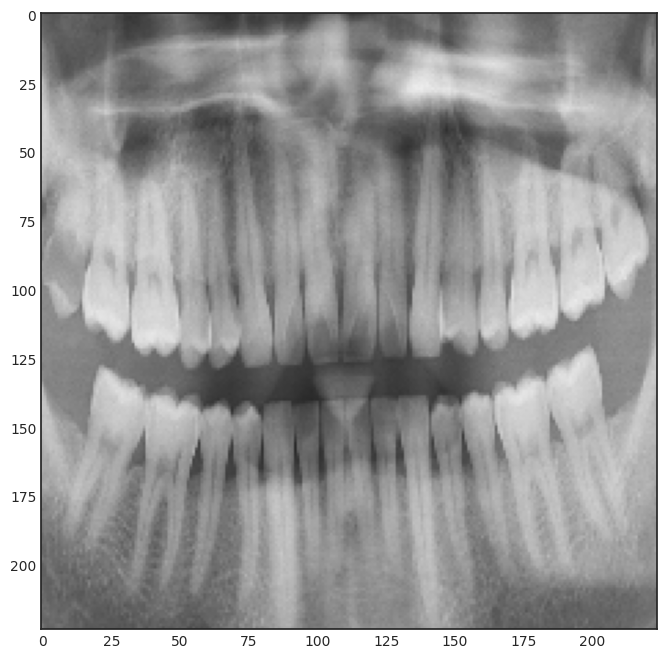

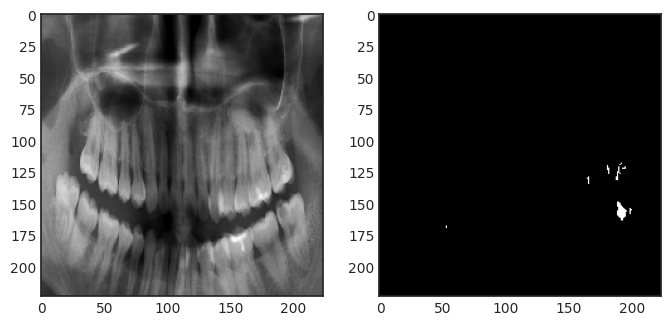

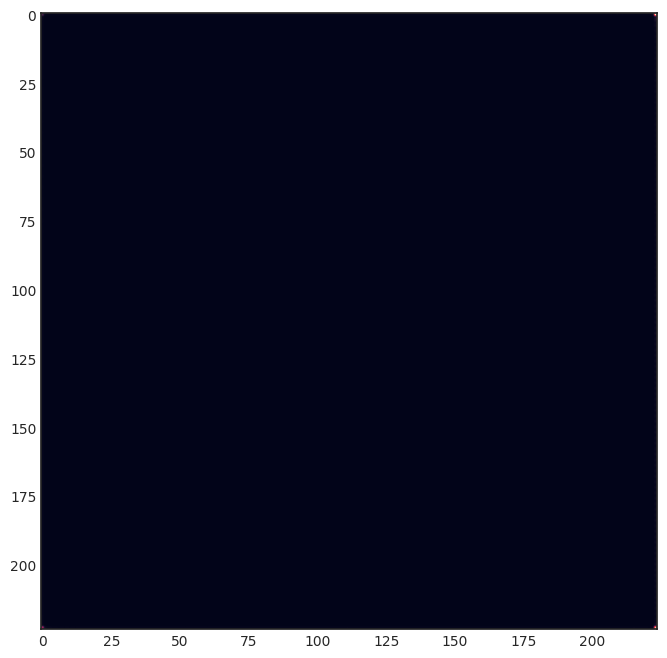

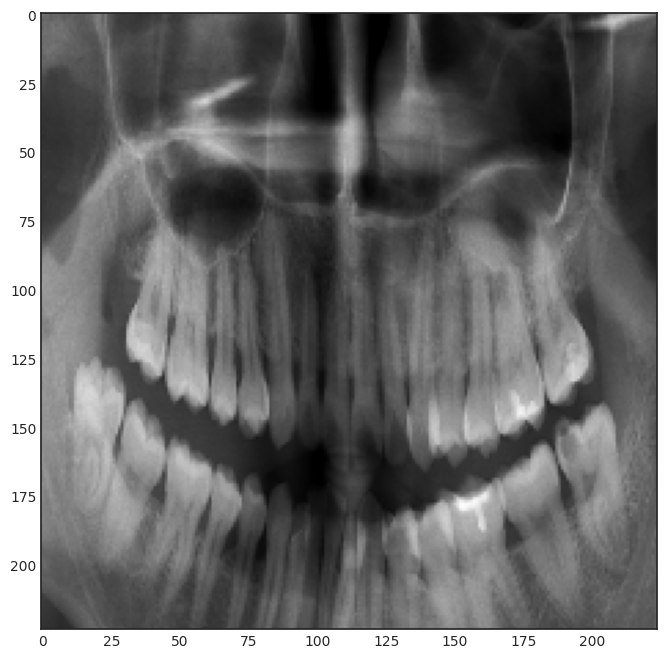

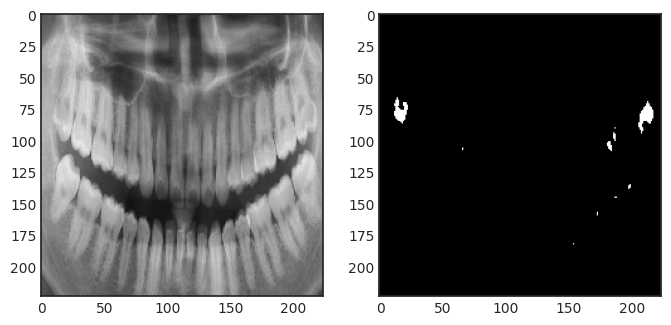

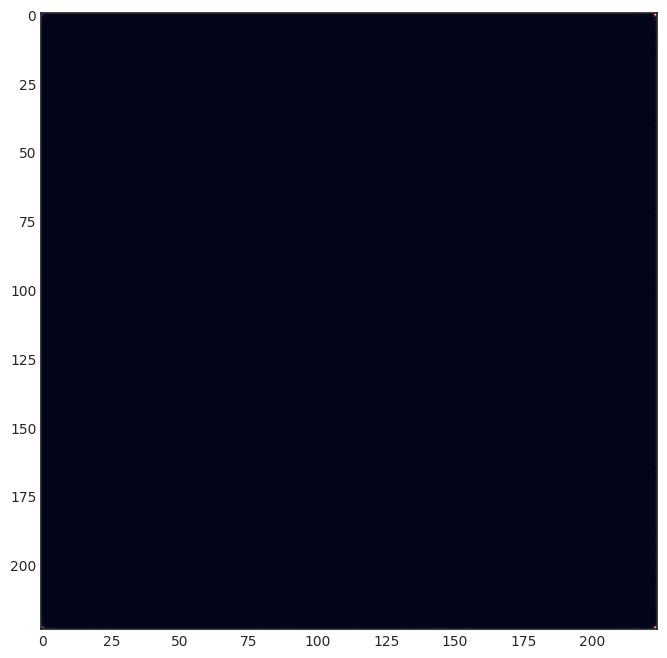

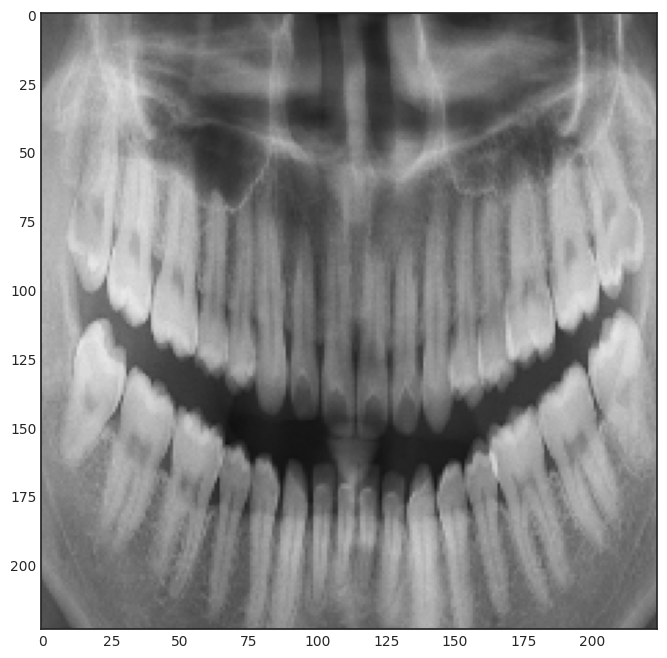

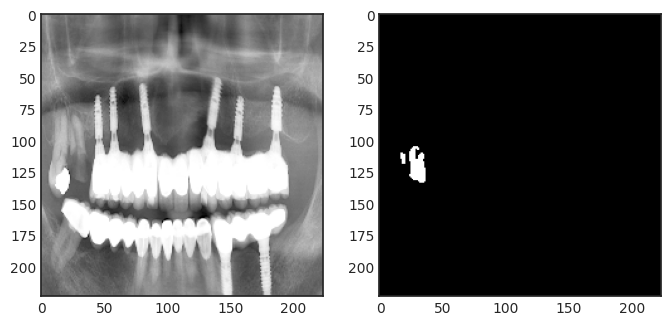

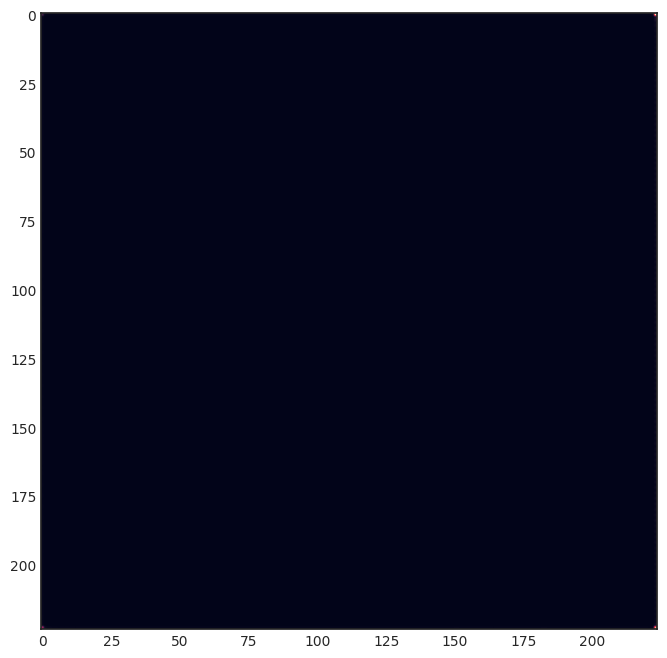

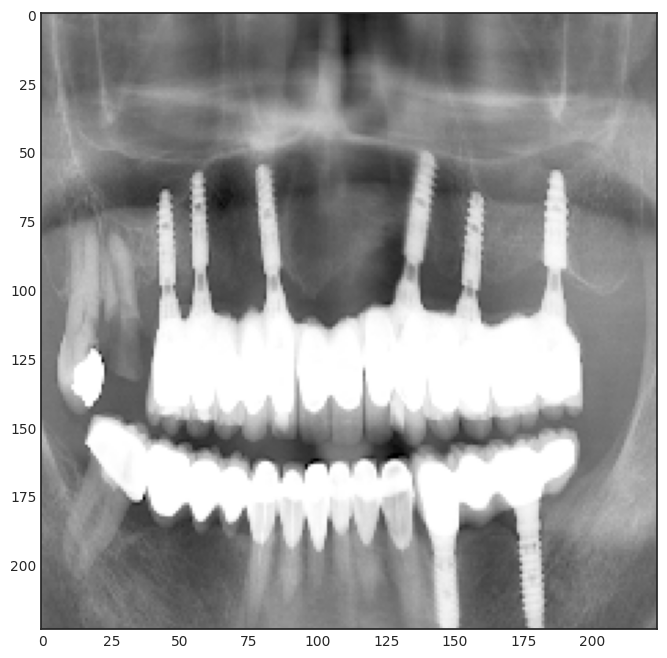

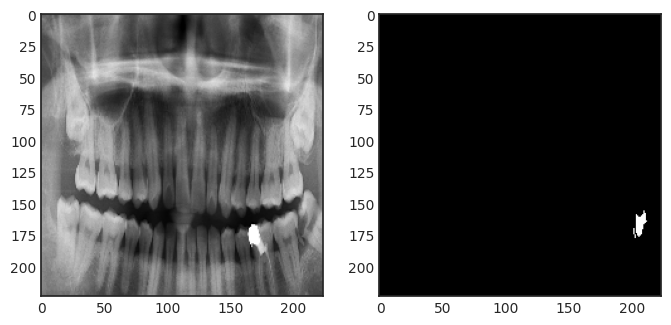

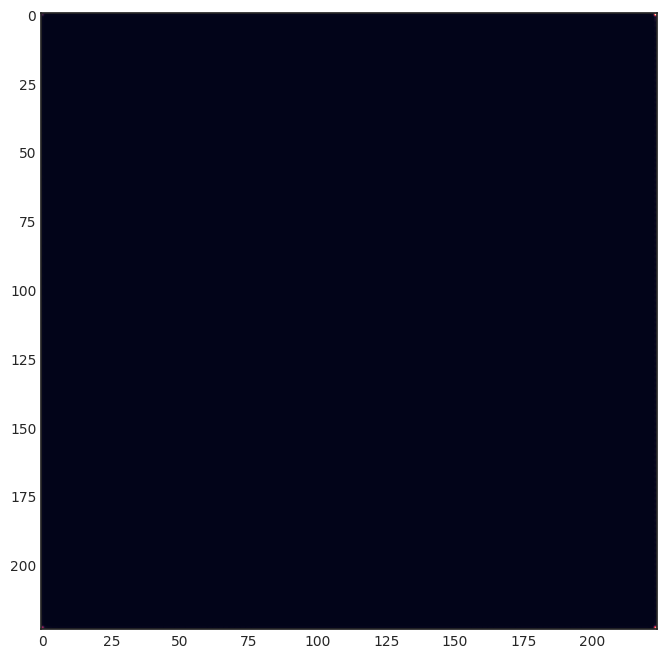

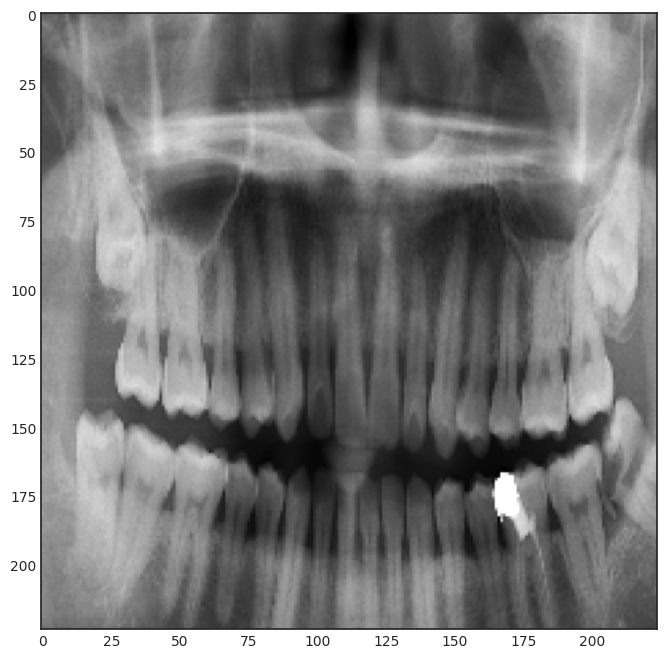

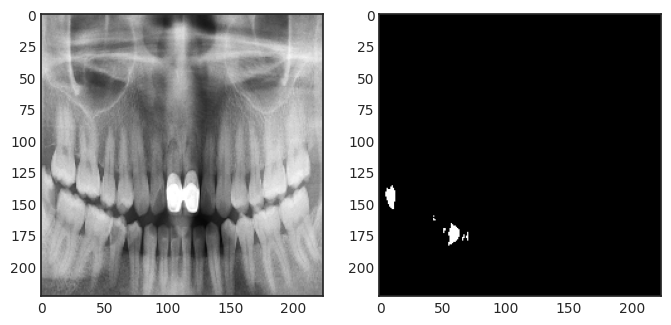

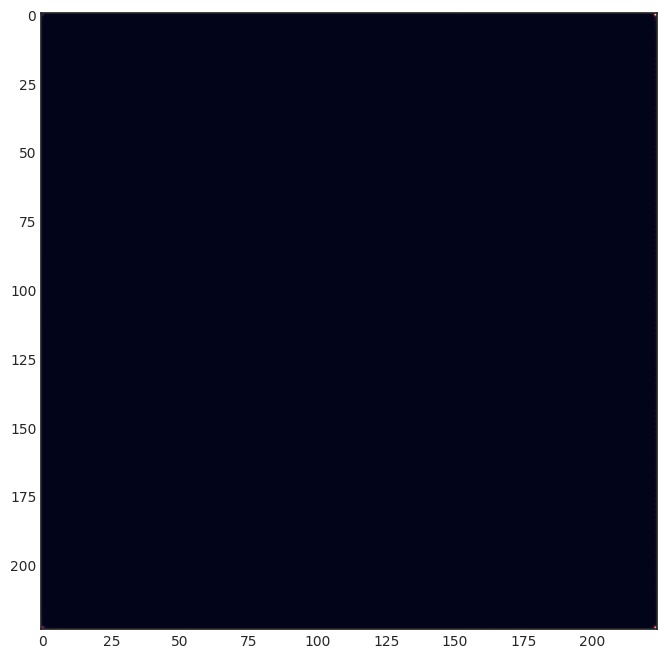

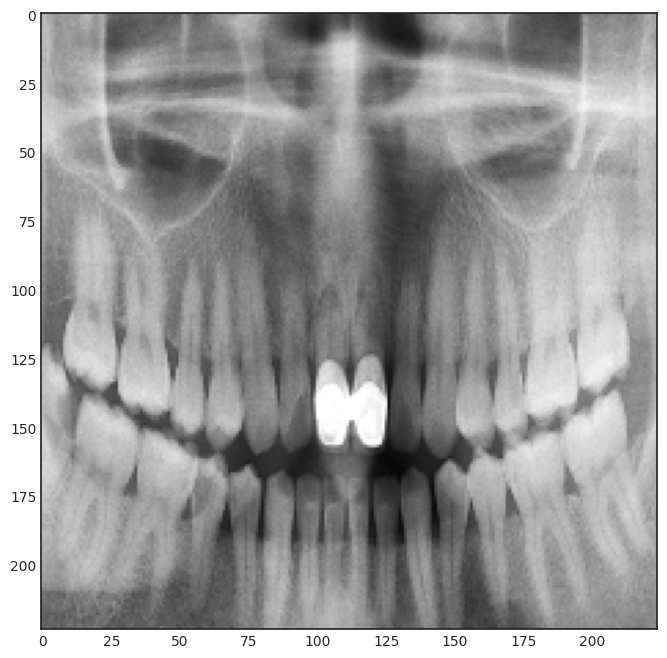

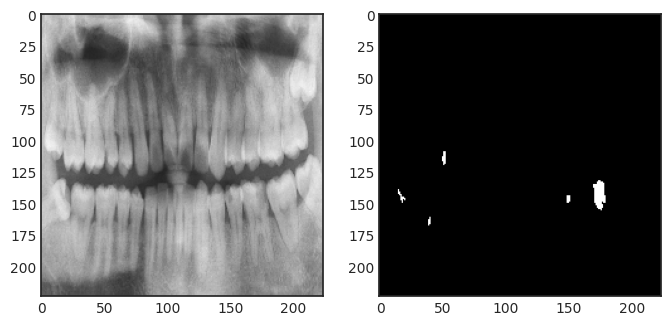

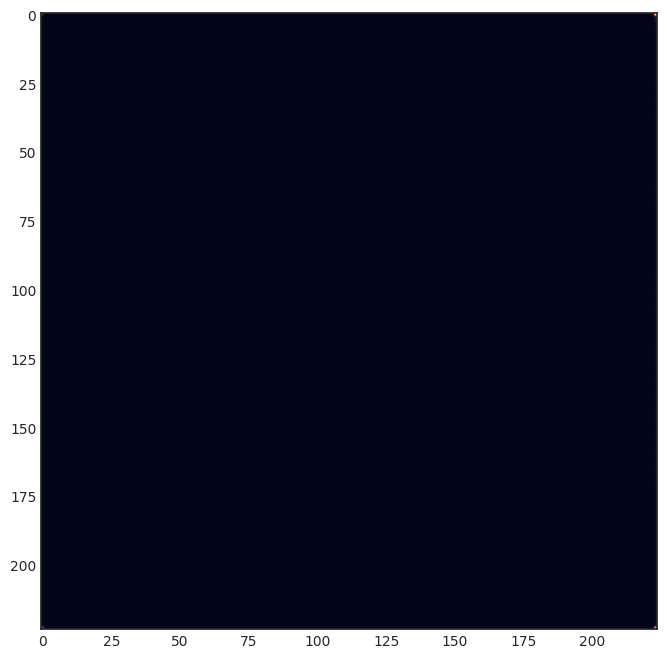

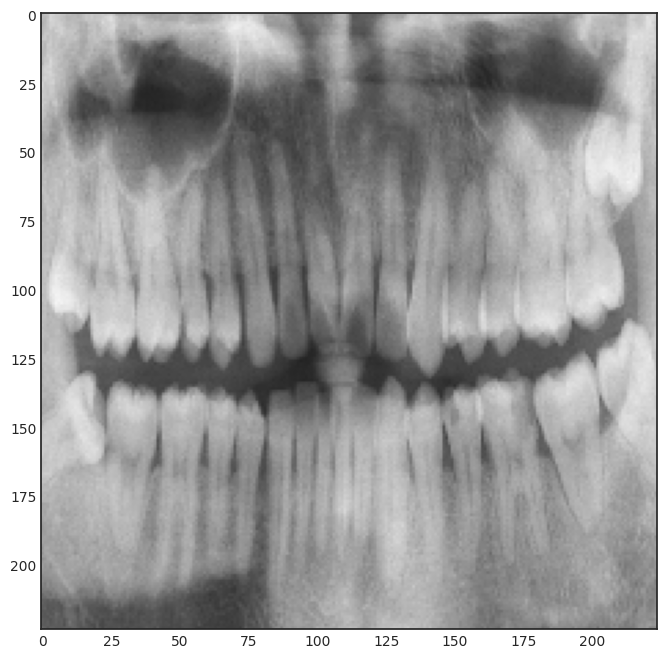

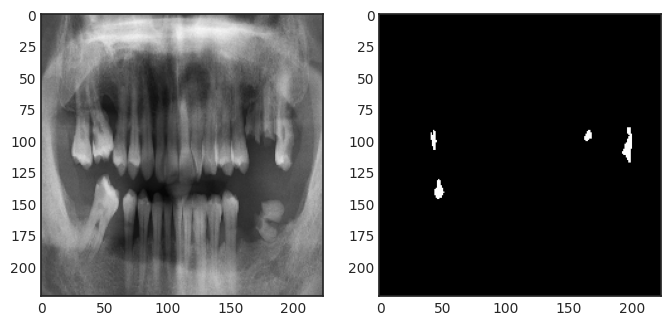

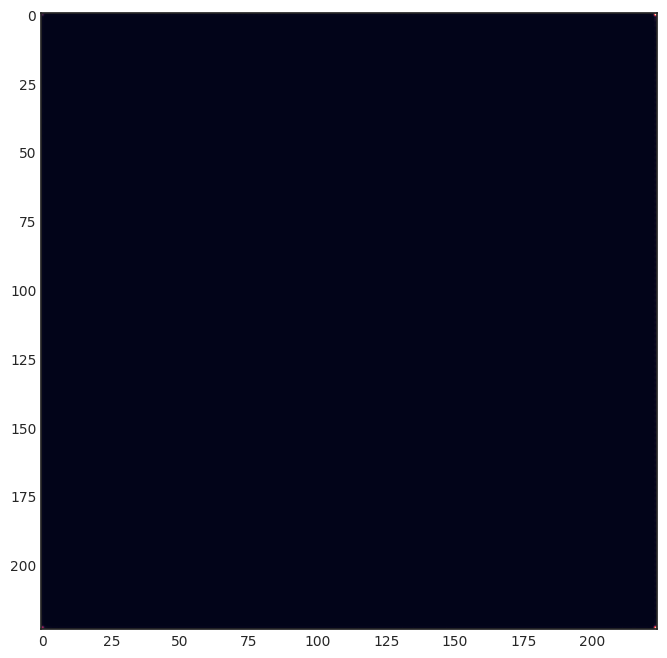

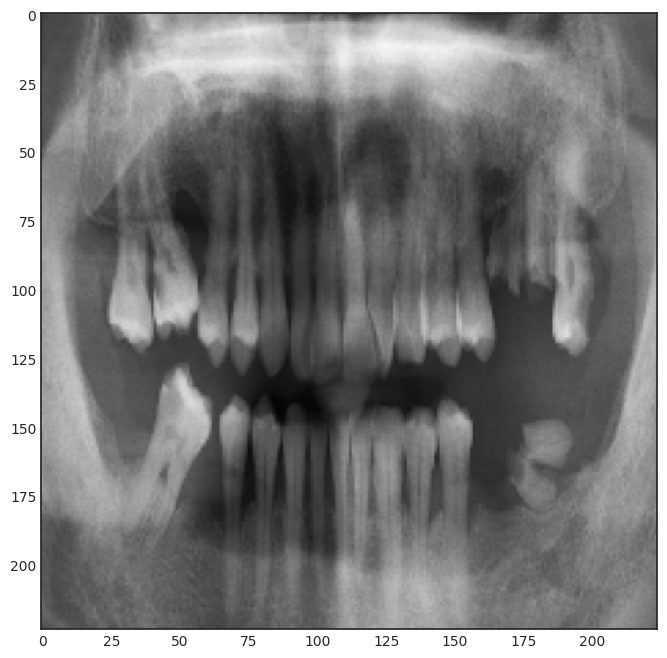

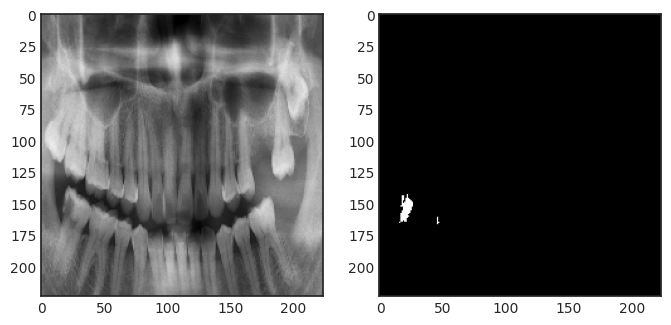

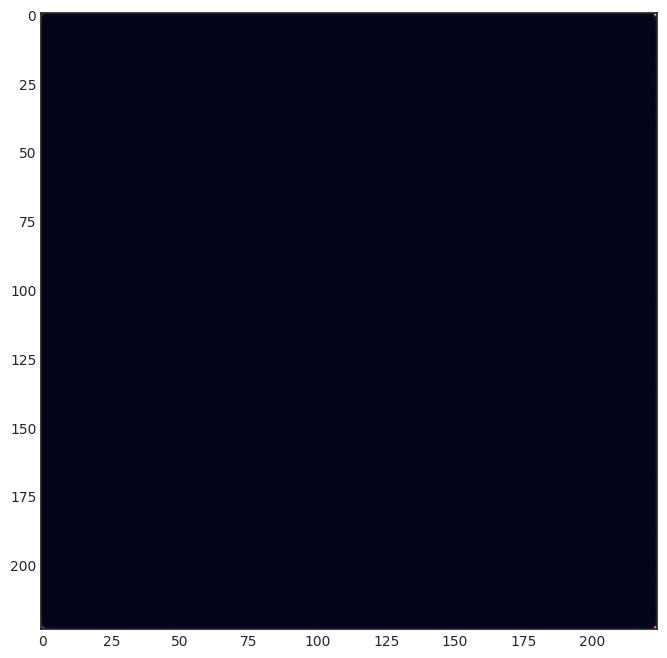

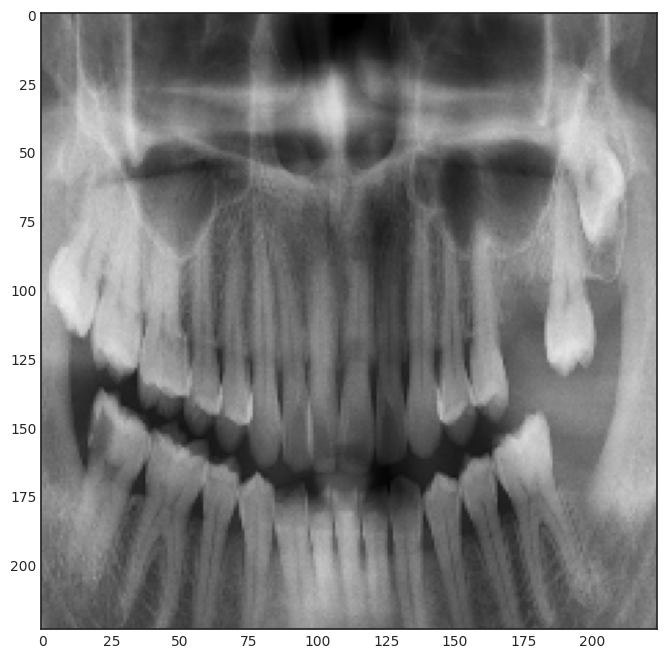

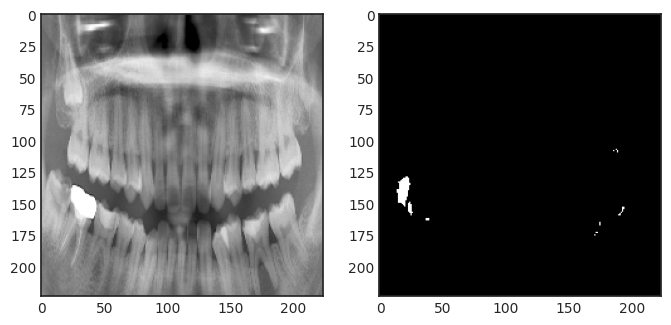

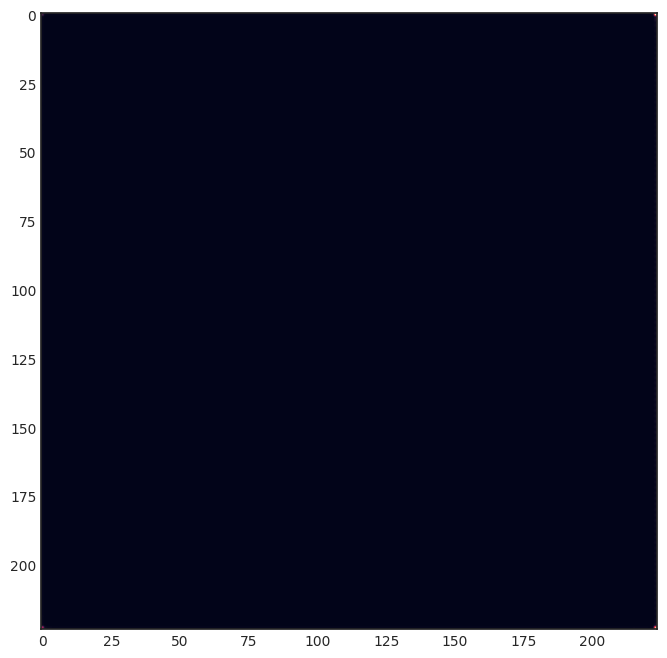

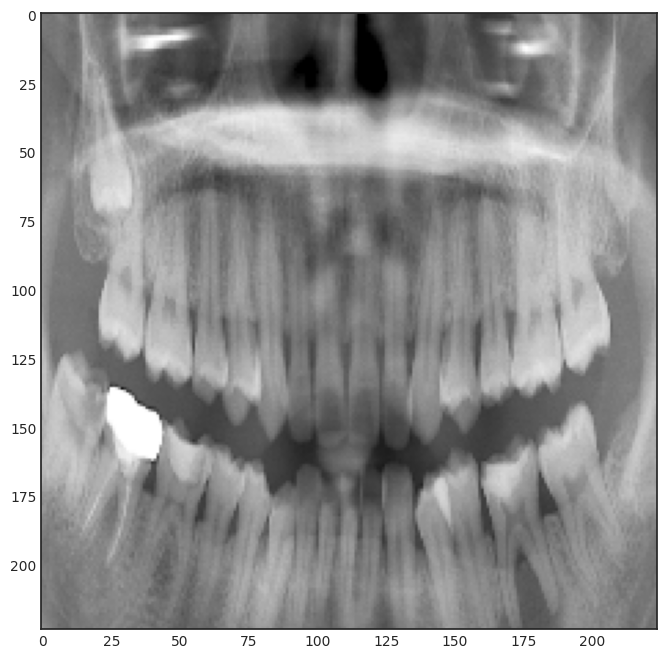

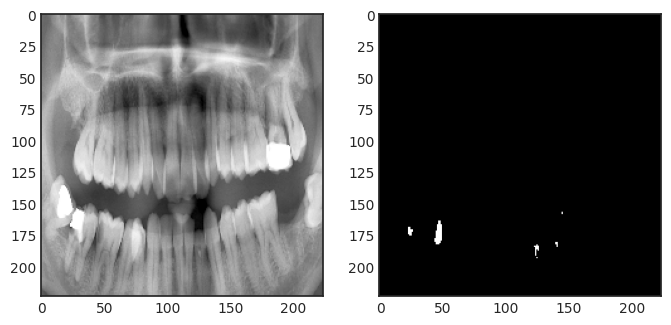

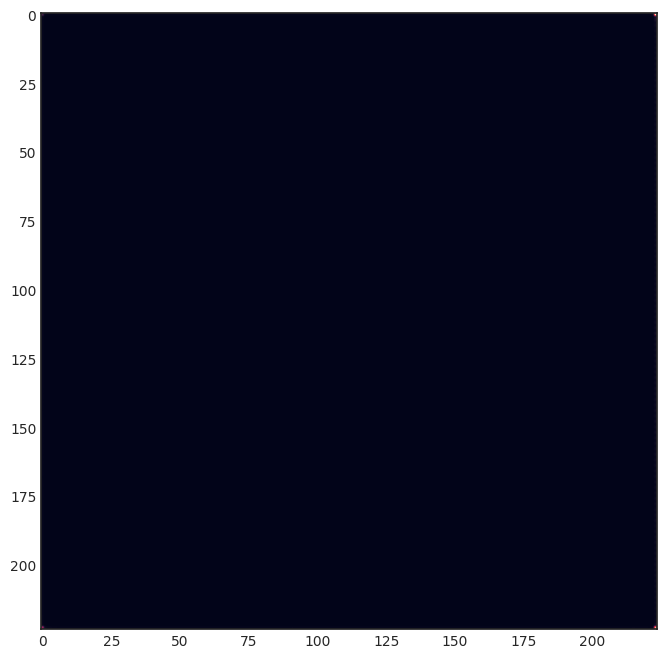

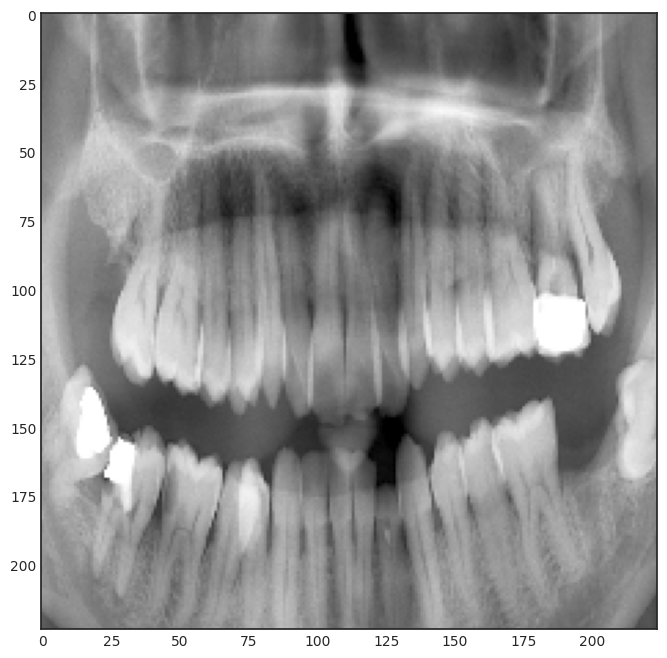

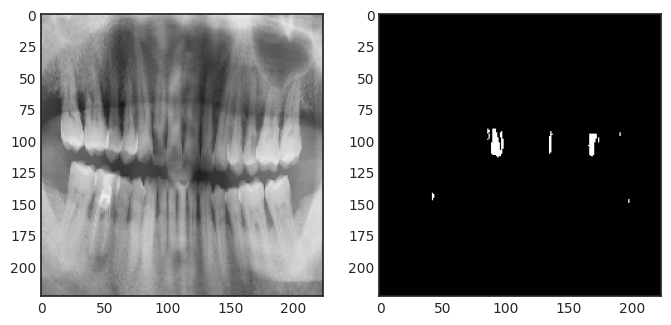

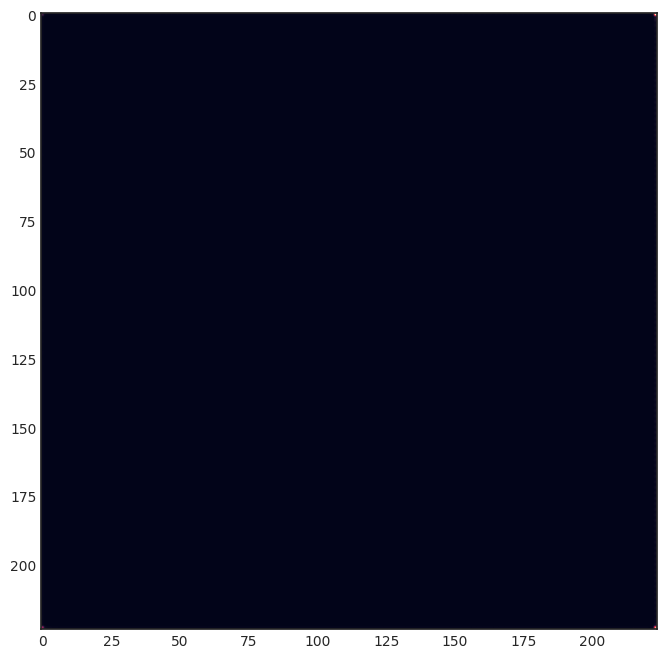

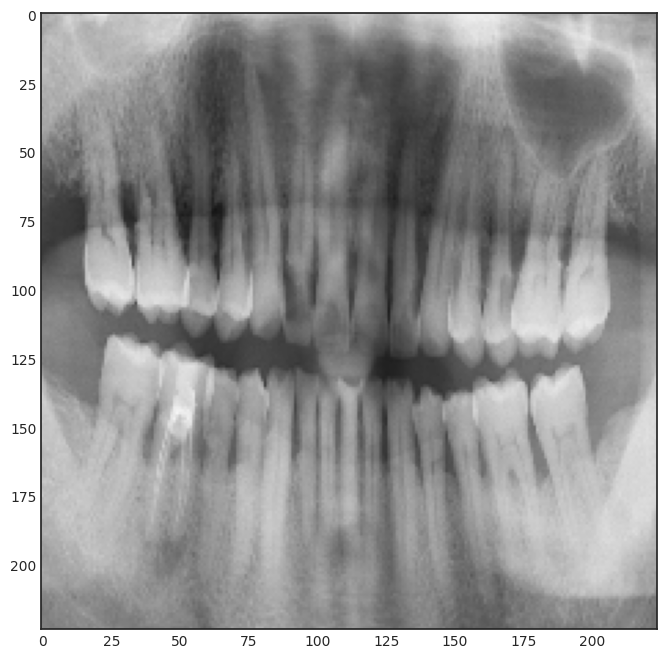

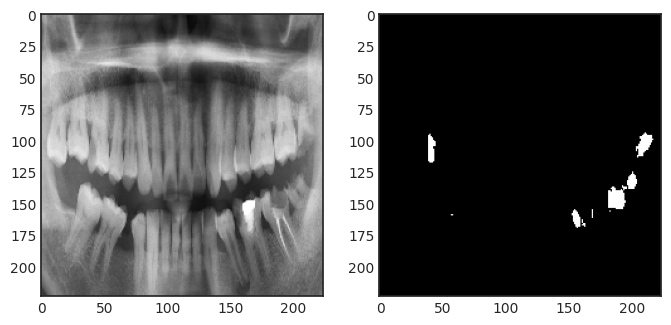

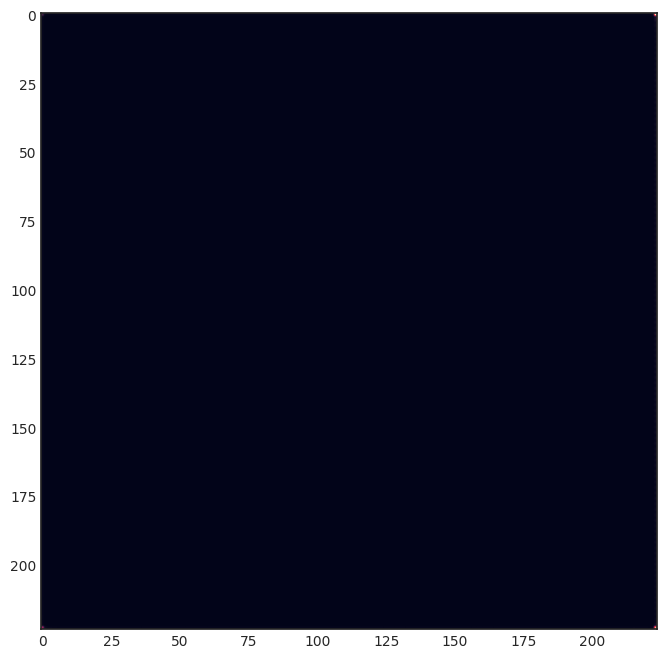

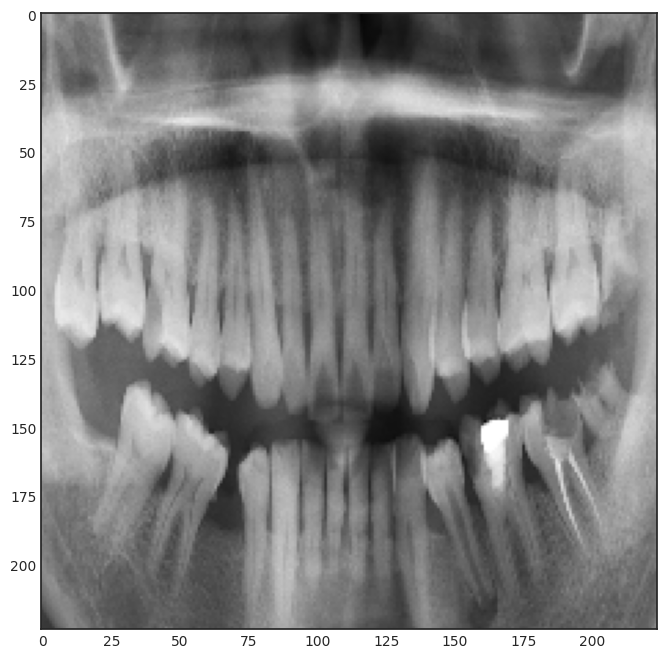

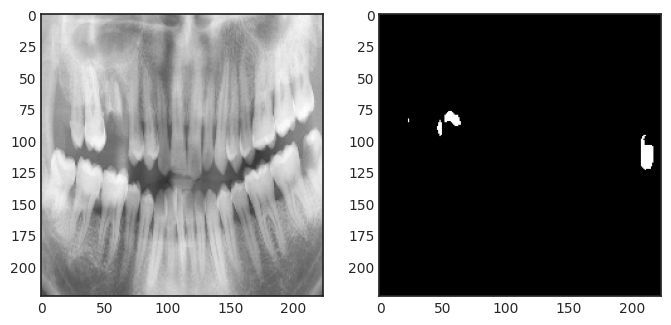

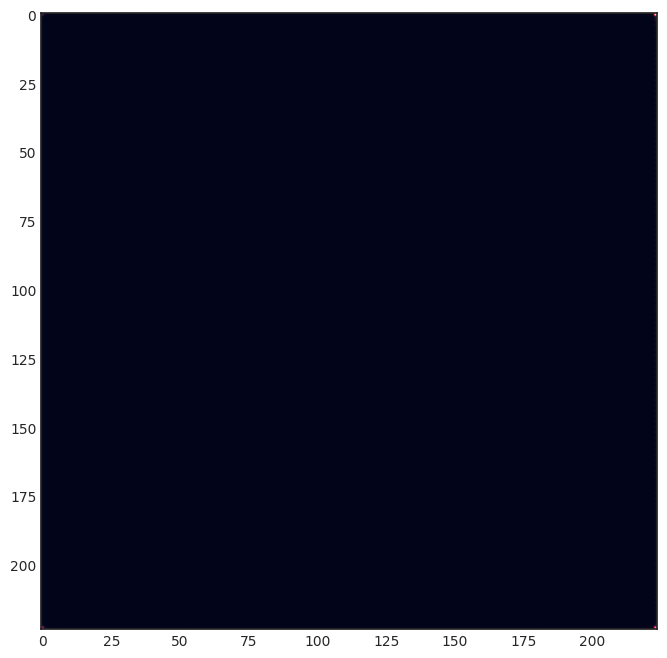

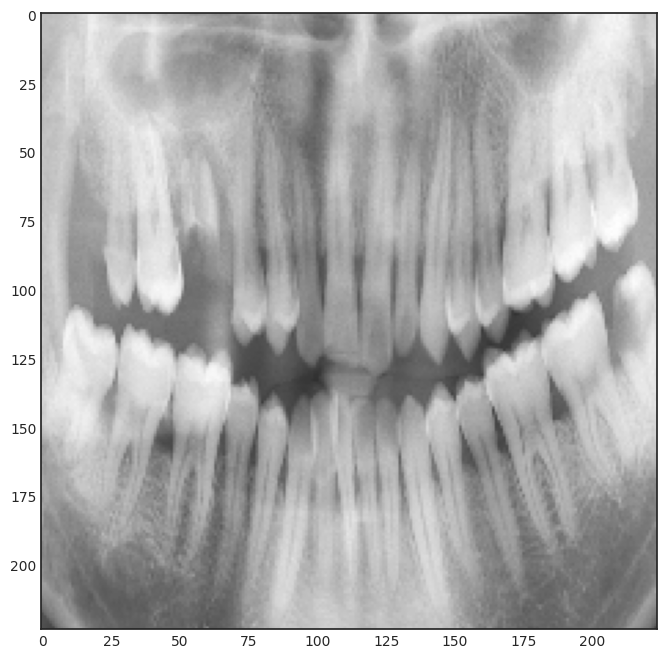

In [ ]:
save_path = '/content/drive/MyDrive/TCC/resultados_resnet'

for i in range(len(val_files)):

  test_image_path = val_files[i]
  image = '/content/drive/MyDrive/TCC/images_cut/' + test_image_path
  img = img_to_array(load_img(image, target_size=(img_w_target, img_h_target, 3))) / 255
  print(img.shape)

  mask = '/content/drive/MyDrive/TCC/labels_cut/' + test_image_path
  mask_img = img_to_array(load_img(mask, target_size=(img_w_target, img_h_target, 3)))

  print(test_image_path)

  plt.figure(figsize=(8,8))
  plt.subplot(121)
  plt.imshow(img)
  plt.subplot(122)
  plt.imshow(mask_img/255.)

  plt.savefig(save_path + '/' + str(i) + '.sample_mask.png')

  plt.figure(figsize=(8,8))

  predicted_mask = make_prediction(model,image,(img_w_target, img_h_target, 3))[0]
  plt.imshow(predicted_mask)
  plt.savefig(save_path + '/' + str(i) + '.predicted_mask.png')

  plt.figure(figsize=(8,8))

  plt.imshow(overlay_mask(img, predicted_mask.squeeze(),color=(255, 0, 0), alpha=0.5))

  plt.savefig(save_path + '/' + str(i) + '.overlay_mask.png')